<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/stn_descriptor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
!git pull origin master

# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


/content
fatal: destination path 'deepLearning' already exists and is not an empty directory.
/content/deepLearning
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
Already up to date.
('RAM Free: 12.9 GB', ' | Proc size: 153.7 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
from common import *
!./setup.sh

Using TensorFlow backend.


--2019-03-11 17:32:59--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.27.197, 107.152.26.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-11 17:32:59--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-11 17:33:00--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

In [0]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet, plot_stn
import matplotlib.pyplot as plt
from layers import BilinearInterpolation

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_stn_model(shape):
    init_weights = keras.initializers.he_normal()
    inputs = Input(shape)
    locnet = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_1')(inputs) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_2')(locnet) # 32
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_3')(locnet)  # 64
    locnet = BatchNormalization(axis = -1)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights, name='stn_4')(locnet)  # 128
    locnet = BatchNormalization(axis = -1)(locnet)
    
    locnet = Flatten()(locnet)
    locnet = Dense(256, name='stn_5')(locnet)
    locnet = Activation('tanh')(locnet)
    weights = get_initial_weights(256)
    locnet = Dense(6, weights=weights, name='stn_6')(locnet)
    stn    = BilinearInterpolation(shape[:-1])([inputs, locnet])
    return Model(inputs=inputs, outputs=stn)

In [4]:
%cd /content/deepLearning
!git pull origin master

/content/deepLearning
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/AlexMontgomerie/deepLearning
 * branch            master     -> FETCH_HEAD
   c2c4011..0caff34  master     -> origin/master
Updating c2c4011..0caff34
Fast-forward
 utils.py | 42 +++++++++++++++++++++++++++++++++++-------
 1 file changed, 35 insertions(+), 7 deletions(-)


In [48]:
from get_data import get_data
from read_data import STNHPatches

seqs_train, seqs_test = get_data()

denoise_generator     = STNHPatches(seqs_train, batch_size=500)
denoise_generator_val = STNHPatches(seqs_test, batch_size=500)

100%|██████████| 40/40 [00:15<00:00,  2.80it/s]


In [50]:
# get model
shape = (32, 32, 1)
stn_model = get_stn_model(shape)

# optimiser
opt  = opt = keras.optimizers.nadam()

# loss
loss = 'mean_absolute_error'

# train network
def ssim_loss(a,p):
  return 1 - tf.image.ssim(a, p, max_val=1.0)

# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/stn_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

stn_model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
stn_history = stn_model.fit_generator(generator=denoise_generator, epochs=50, callbacks=callbacks,
                                              verbose=1, validation_data=denoise_generator_val)

Epoch 1/50
1169/1169 [==============================] - 105s 90ms/step - loss: 27.9566 - acc: 0.0879 - val_loss: 26.1146 - val_acc: 0.0868

Epoch 00001: val_loss improved from inf to 26.11457, saving model to data/stn_model.weights.01-26.11.hdf5
Epoch 2/50
1169/1169 [==============================] - 103s 88ms/step - loss: 27.8775 - acc: 0.0967 - val_loss: 26.0617 - val_acc: 0.0706

Epoch 00002: val_loss improved from 26.11457 to 26.06171, saving model to data/stn_model.weights.02-26.06.hdf5
Epoch 3/50
1169/1169 [==============================] - 101s 86ms/step - loss: 27.8068 - acc: 0.0983 - val_loss: 26.8327 - val_acc: 0.0588

Epoch 00003: val_loss did not improve from 26.06171
Epoch 4/50
1169/1169 [==============================] - 100s 86ms/step - loss: 27.9274 - acc: 0.0994 - val_loss: 26.1085 - val_acc: 0.1112

Epoch 00004: val_loss did not improve from 26.06171
Epoch 5/50
1169/1169 [==============================] - 102s 87ms/step - loss: 27.8747 - acc: 0.1034 - val_loss: 24.482

100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


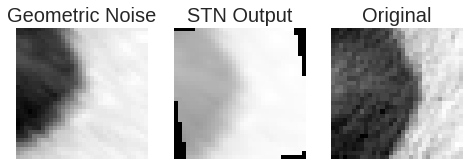

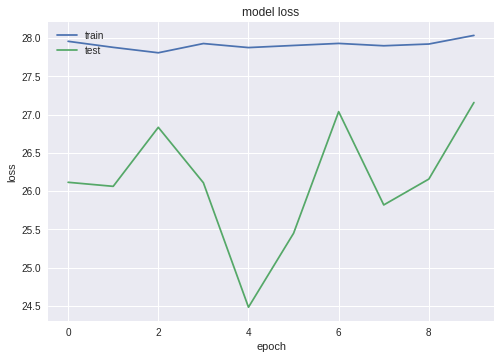

In [58]:
from utils import plot_stn

plot_stn(stn_model)
plt.plot(stn_history.history['loss'])
plt.plot(stn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()